In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [3]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 10. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.03 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge

In [4]:
def model(x, dx, x_node,
          K, beta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 500
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1]
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta)

In [5]:
#now write a test
num_steps = 40000
test_run = [x, dx, x_node, 
            K, beta, 
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, atr, Eh, E, etab, H, eta) = model(*test_run)

20000000.0


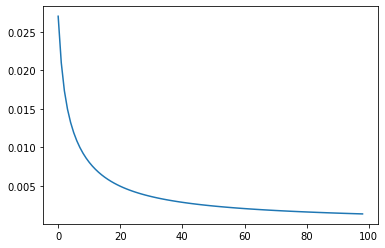

In [6]:
plt.plot(S)

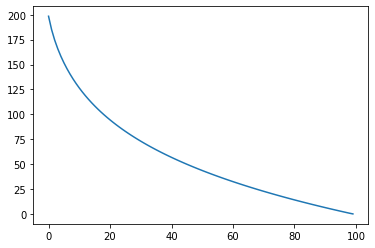

In [7]:
# adjust baselevel
eta_adj = eta - eta[-1]

plt.plot(eta_adj)

In [8]:
# okay, so far looks good... now try comparing to ben's analytical solution
A1 = beta * kqs * I
A2 = (1 - np.exp(-beta * x)) * K
A3 = beta * kqs * I

alpha_Ben = A1 / (A2 + A3)

term_1 = 1 - np.exp(-beta * x)
term_2 = K * Q * alpha_Ben
term_3 = term_1 * term_2 + K * Q
term_4 = (U * B_valley) / alpha_Ben

S_an_Ben = (term_4 / term_3) ** (6 / 7)

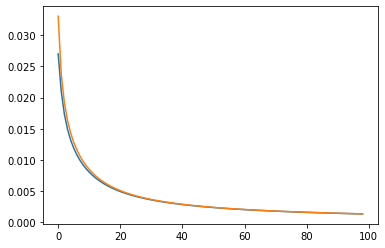

In [9]:
plt.plot(S)
plt.plot(S_an_Ben[1:])

In [10]:
# and what if we make a line using Ben's solution?
eta_an_Ben = np.cumsum(S_an_Ben * dx)

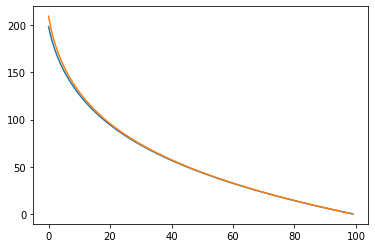

In [11]:
plt.plot(eta_adj)
plt.plot(-(eta_an_Ben - eta_an_Ben[-1]))

In [12]:
# now try comparing model slope to threshold for motion slope, using Eqn 5 from Lai et al 2021)

tau_c = 0.15 * S**(1./4.)
print(tau_c)

[0.06080427 0.05707806 0.05442787 0.05245434 0.05087694 0.04955569
 0.04841425 0.04740708 0.04650489 0.04568769 0.04494111 0.04425441
 0.04361928 0.04302913 0.04247857 0.04196319 0.04147924 0.04102355
 0.04059338 0.04018638 0.03980048 0.03943385 0.03908489 0.03875219
 0.03843445 0.03813056 0.03783948 0.03756031 0.0372922  0.03703441
 0.03678625 0.03654711 0.03631641 0.03609364 0.03587833 0.03567003
 0.03546836 0.03527293 0.03508341 0.03489949 0.03472088 0.03454729
 0.0343785  0.03421425 0.03405433 0.03389855 0.03374671 0.03359863
 0.03345415 0.03331311 0.03317536 0.03304078 0.03290922 0.03278058
 0.03265472 0.03253155 0.03241097 0.03229287 0.03217716 0.03206376
 0.03195259 0.03184356 0.0317366  0.03163165 0.03152863 0.03142748
 0.03132814 0.03123055 0.03113466 0.03104041 0.03094776 0.03085665
 0.03076703 0.03067887 0.03059213 0.03050675 0.0304227  0.03033995
 0.03025846 0.03017819 0.03009911 0.03002119 0.0299444  0.02986871
 0.02979409 0.02972052 0.02964796 0.02957639 0.02950579 0.0294

In [13]:
# this is pretty close to 0.0495 value typically used; but use Lai et al 21 formulation for consistancy

In [14]:
rho_s = 2650
rho_w = 1000
Rb = (rho_s - rho_w)/rho_w

In [15]:
width = (kb * Q[1:] * (S**(7./6.))) / (D**(3./2.))

In [16]:
depth = (0.09801 * D) / S

In [17]:
Rh = (width * depth) / ((2 * depth) + width)

In [18]:
S_ds = (tau_c * Rb * D) / Rh

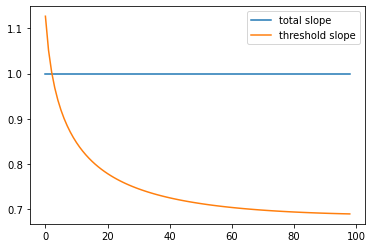

In [19]:
# plt.plot(S_an_Ben, label = 'total slope')
plt.plot(S[:]/S[:], label = 'total slope')
plt.plot(S_ds[:]/S[:], label = 'threshold slope')
plt.legend()

In [20]:
# now calc S_qs
tau = (Rh * S) / (Rb * D)
S_qs = (tau - tau_c) * ((Rb * D)/Rh) * (1 - alpha[:-1])**(2./3.)

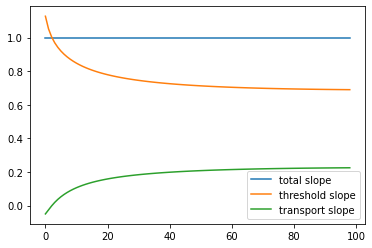

In [21]:
plt.plot(S/S, label = 'total slope')
plt.plot(S_ds/S, label = 'threshold slope')
plt.plot(S_qs/S, label = 'transport slope')
plt.legend()

In [22]:
# now calc erosion slope
S_e = S - S_ds - S_qs

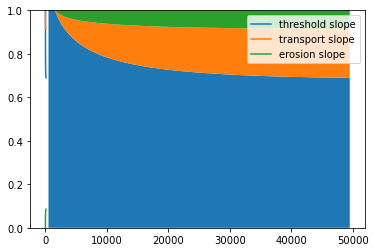

In [23]:
# plt.plot(S/S, label = 'total slope')
# plt.fill_between(x[1:], S/S)
plt.plot(S_ds/S, label = 'threshold slope')
plt.fill_between(x[1:], S_ds/S)
plt.plot(S_qs/S + S_ds/S, label = 'transport slope')
plt.fill_between(x[1:], S_qs/S + S_ds/S, S_ds/S)
plt.plot(S_e/S, label = 'erosion slope')
plt.fill_between(x[1:], S_qs/S + S_ds/S + S_e/S, S_qs/S + S_ds/S)
plt.ylim(0, 1)
plt.legend()

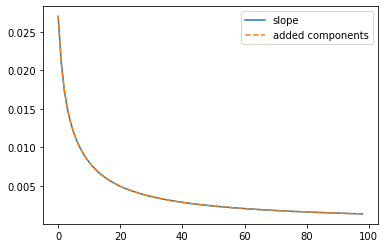

In [25]:
plt.plot(S, label = 'slope')
plt.plot(S_ds + S_qs + S_e, label = 'added components', linestyle = '--')
plt.legend()